### Author: Reinaldo Maciel
### Date: June 9th 2020

## Objective:

Given a Bank customer, build a neural network based classifier that can determine whether they will leave
or not in the next 6 months. 

In [61]:
### Importing libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as ss

from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
from tensorflow.keras import optimizers

In [6]:
### reading data
df_bank = pd.read_csv('Churn_Modelling.csv')
df_bank.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Dropping unique columns like IDs

In [7]:
columns_to_drop = ['RowNumber','CustomerId','Surname']
df_bank.drop(columns=columns_to_drop, inplace=True)
df_bank.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Proceeding with EDA analysis

In [9]:
numerical_vars = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']
df_bank[numerical_vars].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000


This describe is only to check the range of the values.

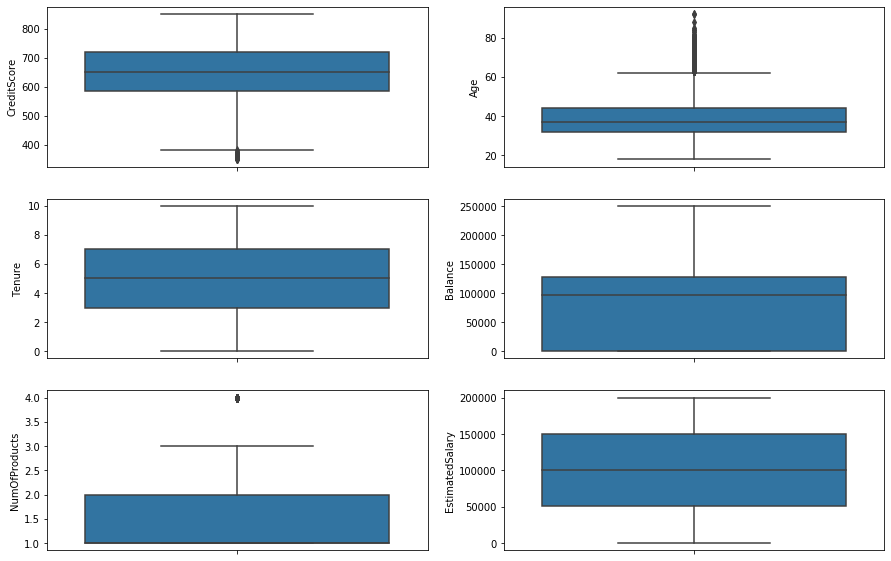

In [10]:
fix, ax = plt.subplots(3,2, figsize=(15,10))
for var, subplot in zip(df_bank[numerical_vars].columns, ax.flatten()):
    sns.boxplot(y=var, data=df_bank, ax=subplot)

By this chart we can see that there's some outliers for age, No of products and credit score. Lets compare all numerical variables with the target variable.

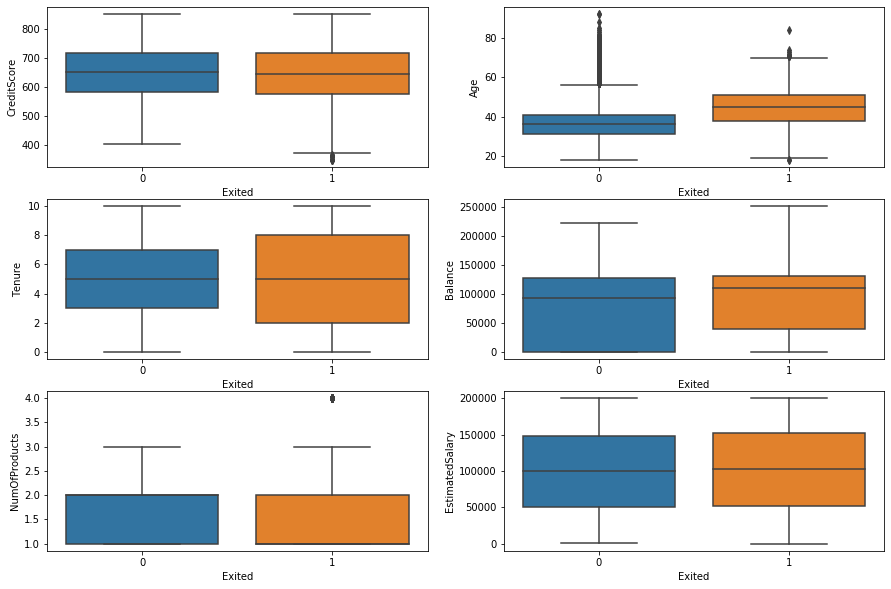

In [11]:
fix, ax = plt.subplots(3,2, figsize=(15,10))
for var, subplot in zip(df_bank[numerical_vars].columns, ax.flatten()):
    sns.boxplot(y=var, x='Exited', data=df_bank, ax=subplot)

With this visualization its more clear the following conclusions

- Older customers are more likely to churn;
- No of products seems having no impact on churn. Same for Estimated salary, CreditScore and Tenure.


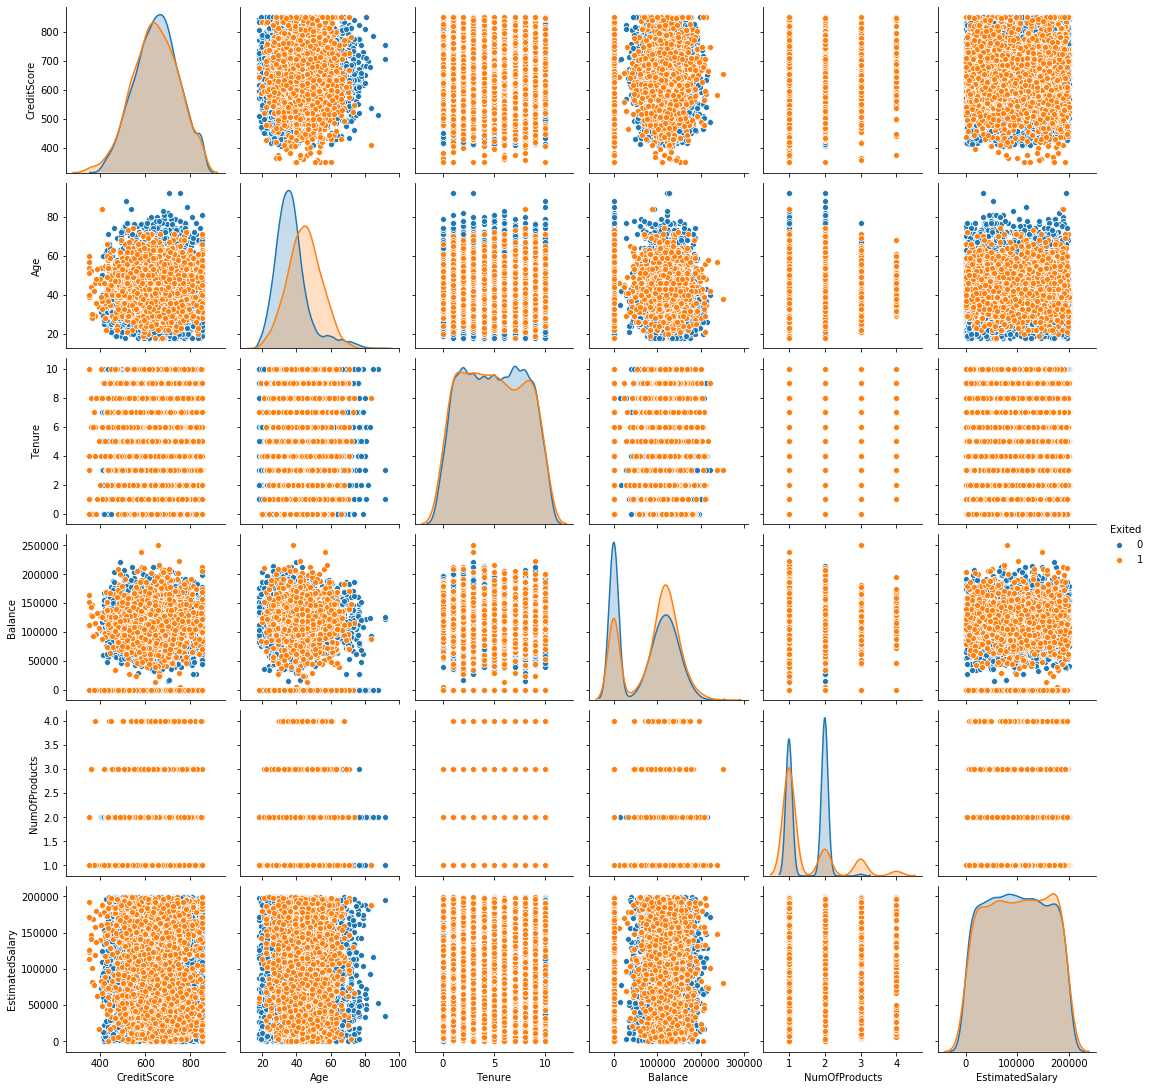

In [13]:
numerical_vars.append('Exited')
ax = sns.pairplot(df_bank[numerical_vars], hue='Exited')

Again, only age can show that there is some difference between those who churn from those who don`t.

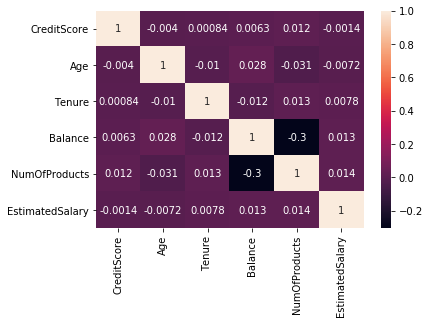

In [21]:
ax = sns.heatmap(df_bank[numerical_vars[:-1]].corr(), annot=True)

Correlation between variables are weak.

In [28]:
### Creating PCAs

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(df_bank[numerical_vars[:-1]])

principalComponentsDf = pd.DataFrame(data=principalComponents, columns=['pca1','pca2'])

#### Evaluating if PCAs have better differentiation between churn and non churn group

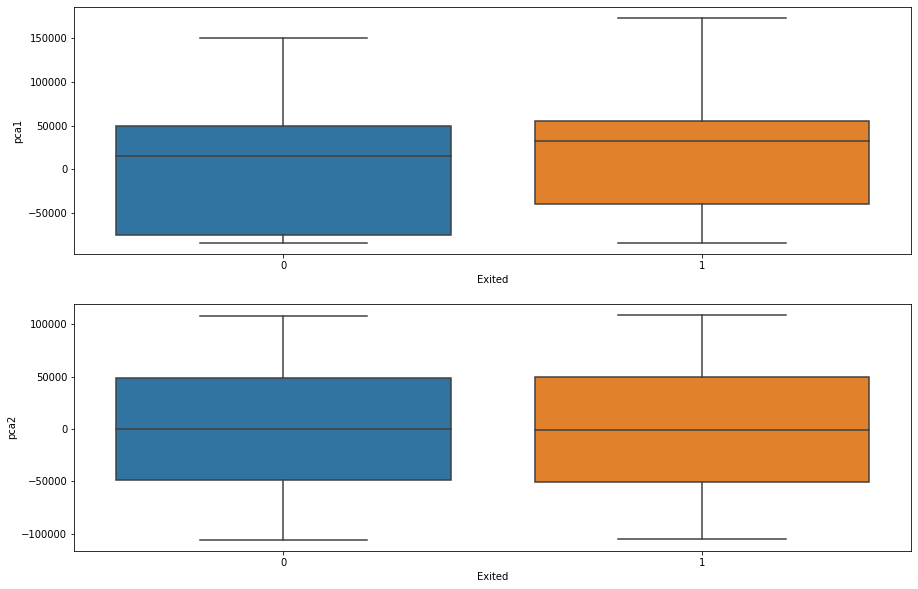

In [30]:
principalComponentsDf['Exited'] = df_bank.Exited
fix, ax = plt.subplots(2,1, figsize=(15,10))
for var, subplot in zip(principalComponentsDf.columns[:-1], ax.flatten()):
    sns.boxplot(y=var, x='Exited', data=principalComponentsDf, ax=subplot)

#### Analysing categorical data

In [32]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [37]:
cat_columns = ['Geography','Gender','HasCrCard','IsActiveMember']

df_categorical_correlations = pd.DataFrame(columns=['X','Y','value'])
for cat_variable in cat_columns:
    try:
        df_categorical_correlations.loc[len(df_categorical_correlations)] = [cat_variable,'Exited',
                                            cramers_v(df_bank[cat_variable],df_bank['Exited'])]
    except:
        pass

In [38]:
df_categorical_correlations.sort_values(by=['value'], ascending=False, inplace=True)
df_categorical_correlations

,X,Y,value
0,Geography,Exited,0.172999
3,IsActiveMember,Exited,0.155567
1,Gender,Exited,0.105797
2,HasCrCard,Exited,0.000000


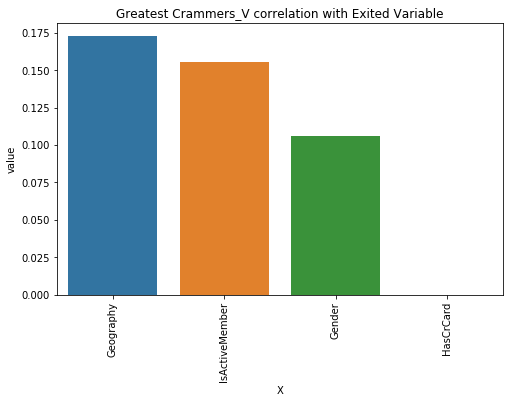

In [41]:
fig, ax = plt.subplots(figsize=(8,5))
plt.title('Greatest Crammers_V correlation with Exited Variable')
plt.xlabel('Crammers_V value')
plt.ylabel('Categorical Variable')
ax = sns.barplot(ax = ax, x=df_categorical_correlations['X'], y=df_categorical_correlations['value'])
ax = ax.set_xticklabels(labels = df_categorical_correlations['X'], rotation=90)

For Crammers V correlation, the near to 1 mean a strong correlation between categorical variable. We can see that HasCrCard is useless for this task. So it is going to be <font color='red'>Excluded</font> from this modelling.

In [45]:
df_categorical = pd.get_dummies(df_bank[['Geography','Gender','IsActiveMember']])

### Normalizing numerical data

In [50]:
df_normalized = principalComponentsDf[['pca1','pca2']].apply(zscore)
df_normalized.describe()

,pca1,pca2
count,1.000000e+04,1.000000e+04
mean,-6.896705e-17,1.116884e-17
std,1.000050e+00,1.000050e+00
min,-1.345995e+00,-1.836236e+00
25%,-1.176168e+00,-8.556235e-01
50%,3.224601e-01,2.903283e-03
75%,8.168813e-01,8.550093e-01
max,2.761919e+00,1.896319e+00


In [52]:
#### joining everything together

df_final = pd.merge(df_normalized, df_categorical, left_index=True, right_index=True)
df_final['target'] = df_bank.Exited
df_final.head(20)

,pca1,pca2,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,target
0,-1.220019,-0.125177,1,1,0,0,1,0,1
1,0.132434,-0.206103,1,0,0,1,1,0,0
2,1.345637,-0.127707,0,1,0,0,1,0,1
3,-1.229377,0.005303,0,1,0,0,1,0,0
4,0.756862,0.430611,1,0,0,1,1,0,0
5,0.657041,-0.811150,0,0,0,1,0,1,1
6,-1.333587,1.458259,1,1,0,0,0,1,0
7,0.639827,-0.281921,0,0,1,0,1,0,1
8,1.015877,0.524834,1,1,0,0,0,1,0
9,0.892936,0.570534,1,1,0,0,0,1,0


### Splitting data into Train and Test sets

In [58]:
X_data = df_final.iloc[:,:-1]
y_data = df_final.iloc[:, -1]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 7)

In [69]:
model = Sequential()

In [70]:
model.add(Dense(64, input_shape = (8,), activation = 'relu'))
model.add(Dense(32, activation = 'tanh'))
model.add(Dense(1, activation = 'sigmoid'))
sgd = optimizers.Adam(lr = 0.001)
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])

In [71]:
model.fit(X_train, y_train, batch_size = 700, epochs = 20, verbose = 1)

Epoch 1/20
12/12 [==============================] - 0s 1ms/step - loss: 0.5577 - accuracy: 0.7769
Epoch 2/20
12/12 [==============================] - 0s 1ms/step - loss: 0.4984 - accuracy: 0.7968
Epoch 3/20
12/12 [==============================] - 0s 1ms/step - loss: 0.4890 - accuracy: 0.7968
Epoch 4/20
12/12 [==============================] - 0s 1ms/step - loss: 0.4819 - accuracy: 0.7968
Epoch 5/20
12/12 [==============================] - 0s 1ms/step - loss: 0.4790 - accuracy: 0.7968
Epoch 6/20
12/12 [==============================] - 0s 1ms/step - loss: 0.4768 - accuracy: 0.7968
Epoch 7/20
12/12 [==============================] - 0s 1ms/step - loss: 0.4755 - accuracy: 0.7968
Epoch 8/20
12/12 [==============================] - 0s 1ms/step - loss: 0.4748 - accuracy: 0.7968
Epoch 9/20
12/12 [==============================] - 0s 1ms/step - loss: 0.4743 - accuracy: 0.7968
Epoch 10/20
12/12 [==============================] - 0s 1ms/step - loss: 0.4740 - accuracy: 0.7968
Epoch 11/20
12/12 [

In [72]:
results = model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 683us/step - loss: 0.4648 - accuracy: 0.7945


In [73]:
print(model.metrics_names)
print(results)

['loss', 'accuracy']
[0.46478721499443054, 0.7944999933242798]
